**Problem:** Company X plans to acquire a website and COO would like to see the estimated impact if company purchases the website. However, the website's traffic is unknown.

**Solutions:** Collect the website traffic from third party tool (e.g SEMRush) and all available GA traffic data. Use linear model to formula the correlation between SERMush traffic and GA traffic in order to predict that website's traffic. Moreover, incorporate the internal conversion rate and financial data to figure out the $ number. 

In [1]:
import pandas as pd
import numpy as np

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [79]:
from tabulate import tabulate

In [35]:
traffic = pd.read_csv('train.csv')

In [36]:
traffic.corr()

,semrush_traffic,ga_traffic
semrush_traffic,1.000000,0.118912
ga_traffic,0.118912,1.000000


In [37]:
traffic.head()

,date_time,semrush_traffic,ga_traffic,site
0,4/1/2016,67060,61853,a.com
1,5/1/2016,85660,62007,a.com
2,6/1/2016,51960,63482,a.com
3,7/1/2016,50360,65621,a.com
4,8/1/2016,43860,64002,a.com


In [ ]:
## Grab the number of c.com
traffic = traffic[traffic['site'] == 'c.com']

In [38]:
x_data = traffic['semrush_traffic']
y_data = traffic['ga_traffic']

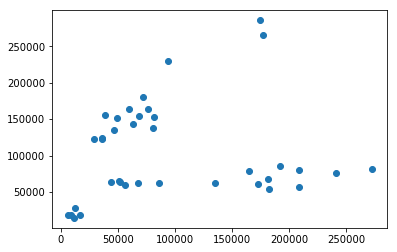

In [39]:
plt.scatter(x_data, y_data)

In [40]:
traffic.corr()

,semrush_traffic,ga_traffic
semrush_traffic,1.000000,0.118912
ga_traffic,0.118912,1.000000


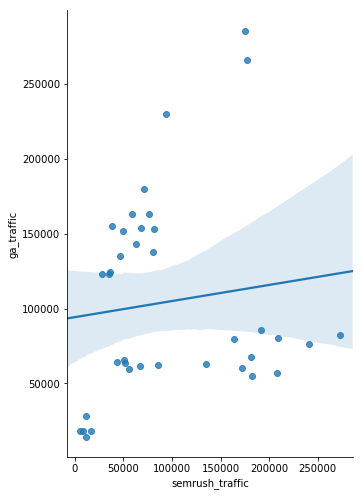

In [41]:
sns.pairplot(traffic, x_vars=['semrush_traffic'], y_vars='ga_traffic', size=7, aspect=0.7, kind='reg')

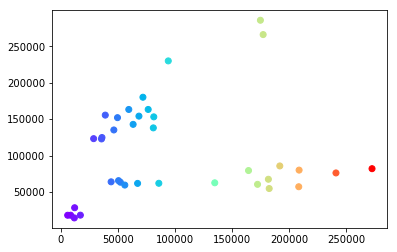

In [42]:
plt.scatter(x_data, y_data, c= x_data, cmap='rainbow')

## KMeans

In [43]:
data = traffic[['semrush_traffic', 'ga_traffic']]

In [44]:
from sklearn.cluster import KMeans

In [45]:
clusters = 2

In [46]:
kmeans = KMeans(n_clusters = clusters)
kmeans.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [47]:
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])

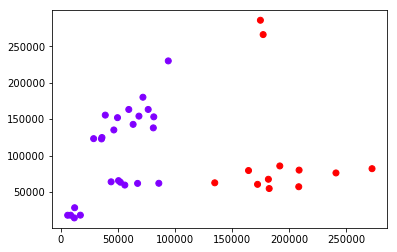

In [48]:
plt.scatter(data['semrush_traffic'],data['ga_traffic'],c=kmeans.labels_, cmap='rainbow')

In [69]:
final_data = data.copy()
final_data['clsuter'] = pd.to_numeric(kmeans.labels_)
# remove the anomaly 
final_data = final_data[final_data['clsuter']==0]

In [70]:
final_data

,semrush_traffic,ga_traffic,clsuter
0,67060,61853,0
1,85660,62007,0
2,51960,63482,0
3,50360,65621,0
4,43860,64002,0
5,55860,59565,0
16,11910,28463,0
17,8410,18215,0
18,11630,14492,0
19,16930,18286,0


In [71]:
final_data.shape

(25, 3)

In [72]:
final_data.corr()

,semrush_traffic,ga_traffic,clsuter
semrush_traffic,1.000000,0.682958,NaN
ga_traffic,0.682958,1.000000,NaN
clsuter,NaN,NaN,NaN


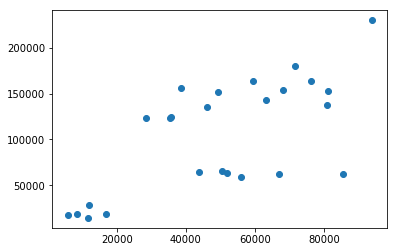

In [57]:
plt.scatter(final_data['semrush_traffic'], final_data['ga_traffic'])

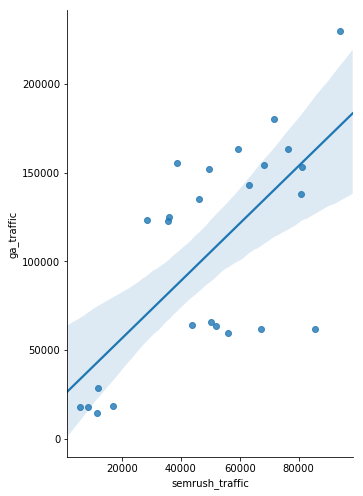

In [58]:
sns.pairplot(final_data, x_vars=['semrush_traffic'], y_vars='ga_traffic', size=7, aspect=0.7, kind='reg')

In [59]:
from sklearn.linear_model import LinearRegression

In [60]:
from sklearn.model_selection import train_test_split

In [61]:
from sklearn import metrics

In [62]:
class SklearnGeneralizedLinearModel(object):
    
    """ Sklearn Generalized Linear Model Object """
    X = None
    y = None
    X_train = None
    X_test  = None
    y_train = None
    y_test  = None
    predictions = None
    model   = None
    
    def __init__(self, data, response, split = 0.3):
        self.data = data
        self.reponse = response
        self.split = split
        self.X = data.drop(response, axis=1)
        self.y = data[response]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=split, random_state=101)
    
    def create_build_model(self):
        self.model = LinearRegression().fit(self.X_train, self.y_train)
        self.predictions = self.model.predict(self.X_test)
    
    def get_coefficient_dataframe(self):
        return pd.DataFrame(self.model.coef_, self.X.columns, columns=['Coefficient'])
        
    def get_coefficient_dataframe(self):
        return pd.DataFrame(self.model.coef_, self.X.columns, columns=['Coefficient'])

    # Residual Histogram
    def plot_residual_chart(self):
        sns.distplot((self.y_test-self.predictions), bins=30)
    
    def get_evaluation_dataframe(self):
        d =  dict()
        d['MAE'] = metrics.mean_absolute_error(self.y_test, self.predictions)
        d['MSE'] = metrics.mean_squared_error(self.y_test, self.predictions)
        d['RMSE'] = np.sqrt(d['MSE'])
        d['Intercept'] = self.model.intercept_
        d['Explained Variance Score'] = metrics.explained_variance_score(self.y_test, self.predictions)
        d['R Square Value'] = metrics.r2_score(self.y_test, self.predictions)
        return pd.DataFrame([d])
    
    def plot_evaluation_scatter_chart(self):
        plt.scatter(self.y_test, self.predictions)
        plt.xlabel('Y Test')
        plt.ylabel('Predicted Y')

In [82]:
def build_model_by_cluster(cluster):
    final_data = data.copy()
    final_data['clsuter'] = pd.to_numeric(kmeans.labels_)
    final_data= final_data[final_data['clsuter']==cluster]
    glm = SklearnGeneralizedLinearModel(final_data[['semrush_traffic', 'ga_traffic']], 'ga_traffic')
    glm.create_build_model()
    return glm

In [83]:
# remove the anomaly 
for cluster in range(clusters):
    print('cluster: {}'.format(cluster))
    glm = build_model_by_cluster(cluster)
    print(tabulate(glm.get_evaluation_dataframe(), headers='keys', tablefmt='psql'))
    print('\n')

cluster: 0
+----+----------------------------+-------------+---------+-------------+------------------+---------+
|    |   Explained Variance Score |   Intercept |     MAE |         MSE |   R Square Value |    RMSE |
|----+----------------------------+-------------+---------+-------------+------------------+---------|
|  0 |                    0.60507 |     29900.1 | 31368.7 | 1.27402e+09 |         0.591542 | 35693.4 |
+----+----------------------------+-------------+---------+-------------+------------------+---------+


cluster: 1
+----+----------------------------+-------------+---------+-------------+------------------+---------+
|    |   Explained Variance Score |   Intercept |     MAE |         MSE |   R Square Value |    RMSE |
|----+----------------------------+-------------+---------+-------------+------------------+---------|
|  0 |                   -4.25763 |      219038 | 44041.2 | 2.65498e+09 |         -13.9089 | 51526.5 |
+----+----------------------------+-------------+

In [86]:
glm = build_model_by_cluster(0)

In [87]:
glm.get_evaluation_dataframe()

,Explained Variance Score,Intercept,MAE,MSE,R Square Value,RMSE
0,0.60507,29900.10257,31368.661497,1.274018e+09,0.591542,35693.383363


In [88]:
glm.get_coefficient_dataframe()

,Coefficient
semrush_traffic,1.547617


In [89]:
glm.model.intercept_

29900.102569639581

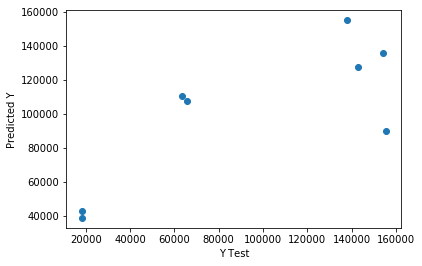

In [90]:
glm.plot_evaluation_scatter_chart()

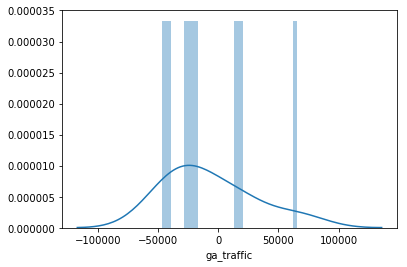

In [91]:
glm.plot_residual_chart()